In [96]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from torch.utils.data import DataLoader
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.visualization import set_seaborn_style
import os
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.spatial.distance import cdist
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.metrics import pairwise_distances
import ast
from prp_visu import *
DATA_PATH = Path(os.getenv("DATA_PATH"))

legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
labels_all = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
cmb_embs_ds = xr.load_dataset("files/cmb_embeddings.nc")

# Filter dataset for short and long conditions
# cmb_embs_ds = cmb_embs_ds.where(
#     (cmb_embs_ds.condition == "short") |
#     ((cmb_embs_ds.condition == "long") & cmb_embs_ds.participant.isin(splits[1])),
#     drop=True
# )
cmb_embs_ds = cmb_embs_ds.where(
    (
        (cmb_embs_ds.condition == "short") |
        ((cmb_embs_ds.condition == "long") & (cmb_embs_ds.participant.isin(splits[1])))
    ) & (cmb_embs_ds.labels == 't1_3'),
    drop=True
)


In [198]:
# Original shape
n_part, n_epoch, n_label, emb_dim = cmb_embs_ds.embeddings.shape

# Flatten to (n_part * n_epoch, emb_dim)
embs_flat = cmb_embs_ds.embeddings.values.reshape(-1, emb_dim)

# Mask out rows that contain any NaNs
valid_mask = ~np.isnan(embs_flat).any(axis=1)
embs_valid = embs_flat[valid_mask]


In [199]:
embs_valid.shape

(14275, 513)

In [200]:
tsne = PCA(n_components=2, random_state=43)
proj_valid = tsne.fit_transform(embs_valid)
# tsne = PCA(n_components=2, random_state=42)
# proj_valid = tsne.fit_transform(embs_valid)
# Create empty array with NaNs
proj_full = np.full((embs_flat.shape[0], 2), np.nan)
proj_full[valid_mask] = proj_valid

# Reshape back to (participant, epoch, 2)
proj_reshaped = proj_full.reshape(n_part, n_epoch, n_label, 2)

In [201]:
cmb_embs_ds['projections'] = (('participant', 'epochs', 'labels', 'proj_dim'), proj_reshaped)

In [182]:
tsne.explained_variance_ratio_

array([0.51594687, 0.11244377], dtype=float32)

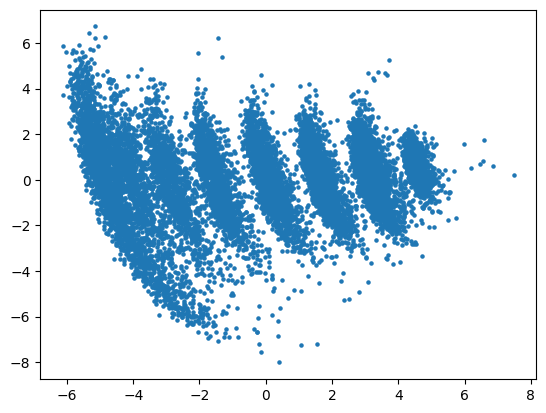

In [202]:
plt.scatter(cmb_embs_ds.projections[:, :, :, 0], cmb_embs_ds.projections[:, :, :, 1], s=5)

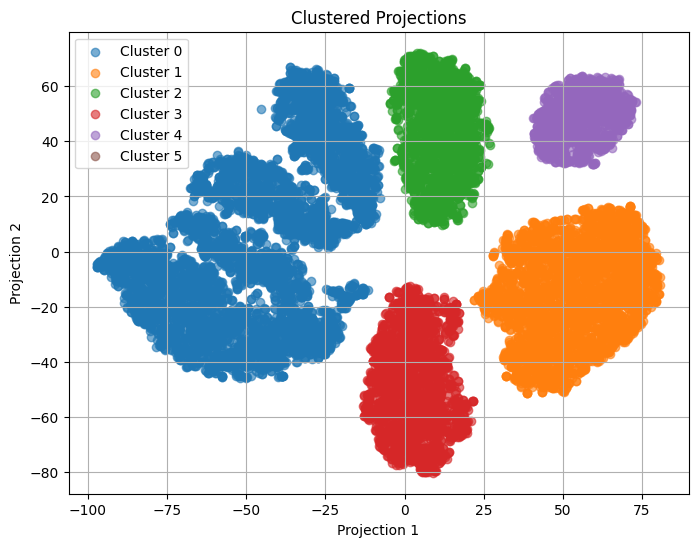

In [138]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Flatten to (N, 2), where N = participant × epochs × labels
proj_array = cmb_embs_ds.projections.values.reshape(-1, 2)

# Remove NaNs
valid_mask = ~np.isnan(proj_array).any(axis=1)
proj_valid = proj_array[valid_mask]
n_clusters = 4  # or use silhouette/DBSCAN to find the best number
kmeans = DBSCAN(eps=5)
cluster_labels = kmeans.fit_predict(proj_valid)

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(cluster_labels))):
    cluster_points = proj_valid[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.6)

plt.title("Clustered Projections")
plt.xlabel("Projection 1")
plt.ylabel("Projection 2")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
np.unique(cluster_labels, return_counts=True)
# Cluster 3 with 1187 points is the suspicious one
# Cluster 2 is other response cluster, compare to this group?

# New clusters
# Response clusters = 2, 3, 4, 5

(array([0, 1, 2, 3, 4, 5, 6]),
 array([28321, 28367, 14496,  9315,  3381,  1186,    59]))

In [203]:
# Create full array filled with NaNs
full_labels = np.full(proj_array.shape[0], np.nan)
full_labels[valid_mask] = cluster_labels

# Reshape to original dims (participant, epoch, labels)
cluster_label_array = full_labels.reshape(
    cmb_embs_ds.sizes["participant"],
    cmb_embs_ds.sizes["epochs"],
    cmb_embs_ds.sizes["labels"]
)
cmb_embs_ds["clusters"] = (("participant", "epochs", "labels"), cluster_label_array)


In [12]:
cmb_embs_ds.to_netcdf("files/cmb_embeddings_clustered.nc")

### Analysis

In [2]:
cmb_embs_ds = xr.load_dataset("files/cmb_embeddings_clustered.nc")

In [33]:
cmb_embs_ds

<xarray.Dataset> Size: 57MB
Dimensions:      (participant: 21, epochs: 1316, labels: 1, emb_dim: 513,
                  proj_dim: 2)
Coordinates:
  * participant  (participant) <U4 336B 'VP1' 'VP10' 'VP11' ... 'VP8' 'VP9'
  * epochs       (epochs) int64 11kB 0 1 2 3 4 5 ... 1311 1312 1313 1314 1315
  * labels       (labels) <U4 16B 't1_3'
  * emb_dim      (emb_dim) int64 4kB 0 1 2 3 4 5 6 ... 507 508 509 510 511 512
Dimensions without coordinates: proj_dim
Data variables:
    embeddings   (participant, epochs, labels, emb_dim) float32 57MB 0.4341 ....
    condition    (participant, epochs, labels) object 221kB 'long' ... nan
    projections  (participant, epochs, labels, proj_dim) float64 442kB -2.656...

In [204]:
proj_df = cmb_embs_ds["projections"].stack(flat_index=("participant", "epochs", "labels"))
s = proj_df.to_series()  

# 2) unstack the proj_dim level so it becomes columns
proj_df = s.unstack(level="proj_dim")

# 3) give them nice names
proj_df.columns = [f"emb_{i+1}" for i in proj_df.columns]

# 4) (optional) pull the flat_index MultiIndex back into columns
proj_df = proj_df.reset_index()
df = proj_df

In [205]:
# df = cmb_embs_ds.stack(index=("participant", "epochs", "labels")).dropna('index', how='all').clusters.to_dataframe().reset_index(drop=True).dropna()
# Flatten condition to DataFrame
condition_df = cmb_embs_ds["condition"].stack(flat_index=("participant", "epochs")).to_dataframe().reset_index(drop=True)
confidence_df = cmb_embs_ds["confidence"].stack(flat_index=("participant", "epochs")).to_dataframe().reset_index(drop=True)


# Merge with cluster info
df = df.merge(condition_df, on=["participant", "epochs"])
df = df.merge(confidence_df, on=["participant", "epochs"])
# df = df.merge(proj_df, on=["participant", "epochs", "labels"])

# rename epochs col to epoch
df = df.rename(columns={"epochs": "epoch"})

In [141]:
df

participant  epoch labels      emb_1      emb_2 condition  confidence
0             VP1      0   t1_3 -24.938416 -26.108025      long    0.057320
1             VP1      1   t1_3 -66.216751 -32.352066      long    0.051665
2             VP1      2   t1_3 -41.421085  30.195496     short    0.042992
3             VP1      3   t1_3  40.268459 -35.821339     short    0.027745
4             VP1      4   t1_3 -41.381138 -40.807510     short    0.069857
...           ...    ...    ...        ...        ...       ...         ...
27631         VP9   1311   t1_3        NaN        NaN       NaN         NaN
27632         VP9   1312   t1_3        NaN        NaN       NaN         NaN
27633         VP9   1313   t1_3        NaN        NaN       NaN         NaN
27634         VP9   1314   t1_3        NaN        NaN       NaN         NaN
27635         VP9   1315   t1_3        NaN        NaN       NaN         NaN

[27636 rows x 7 columns]

In [206]:
def determine_order_cmb(path):
    df = pd.read_csv(path)
    df_t1 = df[df["task"] == "prp1/t1"].copy()
    df_t2 = df[df["task"] == "prp1/t2"].copy()
    
    df_t1["correct_t1"] = df_t1["correct"]
    df_t2["correct_t2"] = df_t2["correct"]
    df_t1["rt_t1"] = df_t1["rt_samples"]
    df_t2["rt_t2"] = df_t2["rt_samples"]

    id_cols = ["participant", "epoch"]
    meta_cols = ["condition", "interval", "rt_t1", "rt_samples"]
    t1_cols = [col for col in df.columns if col.startswith("t1_")]
    t2_cols = [col for col in df.columns if col.startswith("t2_")]


    df_t1_reduced = df_t1[id_cols + meta_cols + ["correct_t1"] + t1_cols]
    df_t2_reduced = df_t2[id_cols + ["correct_t2", "rt_t2"] + t2_cols]

    df_merged_fixed = pd.merge(df_t1_reduced, df_t2_reduced, on=id_cols, how="inner")

    t1_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t1_") and col.endswith("_pred")]
    t2_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t2_") and col.endswith("_pred")]
    df_merged_fixed[t2_pred_cols] = df_merged_fixed[t2_pred_cols].add(df_merged_fixed["interval"] * 250, axis=0)

    peak_order = df_merged_fixed[t1_pred_cols + t2_pred_cols].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(t1_pred_cols + t2_pred_cols):
        df_merged_fixed[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df_merged_fixed

def remove_rare_orders(df: pd.DataFrame, labels: list[list[str]]):
    # Create a column with order tuples
    order_columns = [
        f"event_{i}_idx" for i in range(len(labels[0]) + len(labels[1]) - 2)
    ]
    df["order"] = df[order_columns].apply(tuple, axis=1)

    # Count number of (order, condition) pairs
    order_condition_counts = df.groupby(["order", "condition"]).size()
    print(order_condition_counts)
    # Calculate 1.5% threshold per condition
    condition_counts = df["condition"].value_counts()
    thresholds = condition_counts * 0.015

    # Keep only (order, condition) pairs above threshold
    valid_combinations = [
        (order, condition)
        for (order, condition), count in order_condition_counts.items()
        if count >= thresholds[condition]
    ]

    # Filter the DataFrame
    df = df[df.set_index(["order", "condition"]).index.isin(valid_combinations)]

    # Re-index orders
    unique_orders = df["order"].unique()
    order_mapping = {order: idx for idx, order in enumerate(unique_orders)}
    df["order_idx"] = df["order"].map(order_mapping)

    return df

df_meta = determine_order_cmb(Path("files/cmb_peaks.csv"))
df_meta = remove_rare_orders(df_meta, labels_all)
df_meta['epoch'] = df_meta['epoch'].astype(int)


order               condition
(0, 1, 2, 3, 4, 5)  long         10925
                    short          774
(0, 1, 3, 2, 4, 5)  long            75
                    short         5422
(0, 1, 3, 4, 2, 5)  long             7
                    short          634
(0, 1, 4, 3, 2, 5)  short            1
(0, 3, 1, 2, 4, 5)  long             4
                    short         3059
(0, 3, 1, 4, 2, 5)  long             4
                    short         1708
(0, 3, 1, 4, 5, 2)  short            3
(0, 3, 4, 1, 2, 5)  short          181
(0, 3, 4, 1, 5, 2)  short            2
(0, 3, 4, 5, 1, 2)  short            4
(1, 0, 2, 3, 4, 5)  long             2
dtype: int64


/tmp/ipykernel_1128638/1043114494.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


In [207]:
df = df.merge(df_meta, on=["participant", "epoch", "condition"], how="inner")

In [114]:
df

participant  epoch labels     emb_1     emb_2 condition  confidence  \
0             VP1      1   t1_3 -5.047058 -0.326372      long    0.051665   
1             VP1      2   t1_3 -2.713632  0.202386     short    0.042992   
2             VP1      3   t1_3  3.422182 -1.134343     short    0.027745   
3             VP1      4   t1_3 -4.287114 -3.079576     short    0.069857   
4             VP1      5   t1_3 -0.485908 -3.249939      long    0.049616   
...           ...    ...    ...       ...       ...       ...         ...   
13859         VP9   1287   t1_3  4.392524  0.464420     short    0.043545   
13860         VP9   1288   t1_3  2.782254 -0.090981     short    0.052874   
13861         VP9   1291   t1_3  0.389626 -1.370667     short    0.040817   
13862         VP9   1292   t1_3  0.258121 -0.376072     short    0.037790   
13863         VP9   1293   t1_3  1.876486 -0.200177     short    0.033936   

       interval  rt_t1  rt_samples  ...  t2_3_true  \
0      1.177734    183         183  ...      152.0   
1      0.275391    146         146  ...      114.0   
2      0.277344    192         192  ...      119.0   
3      0.275391    220         220  ...      191.0   
4      1.175781    251         251  ...       98.0   
...         ...    ...         ...  ...        ...   
13859  0.277344    136         136  ...      104.0   
13860  0.277344    157         157  ...      151.0   
13861  0.277344    197         197  ...      215.0   
13862  0.277344    153         153  ...      133.0   
13863  0.277344    141         141  ...      161.0   

                                        t2_3_peak_values  event_0_idx  \
0      [-5.919742107391357, -4.222636699676514, -4.66...            0   
1      [-0.3750690519809723, 1.2942081689834595, -0.0...            0   
2      [-1.5814576148986816, -2.9737422466278076, 0.1...            0   
3      [1.0000470876693726, -2.994112730026245, -0.35...            0   
4      [-5.761991024017334, -4.9951252937316895, -3.3...            0   
...                                                  ...          ...   
13859  [-1.7010445594787598, -3.2945079803466797, -2....            0   
13860  [-4.198360919952393, -2.951665163040161, -4.71...            0   
13861  [0.5038385987281799, 1.2843936681747437, -3.46...            0   
13862  [-2.283954620361328, -4.022957801818848, -0.00...            0   
13863  [0.35982605814933777, 1.422956943511963, 1.040...            0   

      event_1_idx  event_2_idx  event_3_idx event_4_idx  event_5_idx  \
0               1            2            3           4            5   
1               1            3            2           4            5   
2               3            1            4           2            5   
3               3            1            2           4            5   
4               1            2            3           4            5   
...           ...          ...          ...         ...          ...   
13859           1            3            2           4            5   
13860           1            3            2           4            5   
13861           1            3            4           2            5   
13862           1            3            2           4            5   
13863           1            3            2           4            5   

                    order order_idx  
0      (0, 1, 2, 3, 4, 5)         0  
1      (0, 1, 3, 2, 4, 5)         1  
2      (0, 3, 1, 4, 2, 5)         3  
3      (0, 3, 1, 2, 4, 5)         2  
4      (0, 1, 2, 3, 4, 5)         0  
...                   ...       ...  
13859  (0, 1, 3, 2, 4, 5)         1  
13860  (0, 1, 3, 2, 4, 5)         1  
13861  (0, 1, 3, 4, 2, 5)         4  
13862  (0, 1, 3, 2, 4, 5)         1  
13863  (0, 1, 3, 2, 4, 5)         1  

[13864 rows x 39 columns]

In [209]:
from scipy.stats import pearsonr

r, p = pearsonr(df['emb_2'], df['t1_3_pred'])
print(f"r = {r:.3f}, p = {p:.3e}")
r, p = pearsonr(df['emb_2'], df['rt_t1'])
print(f"r = {r:.3f}, p = {p:.3e}")
r, p = pearsonr(df['emb_1'], df['t1_3_pred'])
print(f"r = {r:.3f}, p = {p:.3e}")
r, p = pearsonr(df['emb_1'], df['rt_t1'])
print(f"r = {r:.3f}, p = {p:.3e}")
r, p = pearsonr(df['emb_1'], df['confidence'])
print(f"r = {r:.3f}, p = {p:.3e}")
r, p = pearsonr(df['emb_2'], df['confidence'])
print(f"r = {r:.3f}, p = {p:.3e}")
# r, p = pearsonr(df['emb_1'], df['rt_t1'])
# print(f"r = {r:.3f}, p = {p:.3e}")

r = -0.894, p = 0.000e+00
r = -0.881, p = 0.000e+00
r = -0.121, p = 3.576e-46
r = -0.178, p = 4.185e-99
r = -0.420, p = 0.000e+00
r = -0.046, p = 4.628e-08


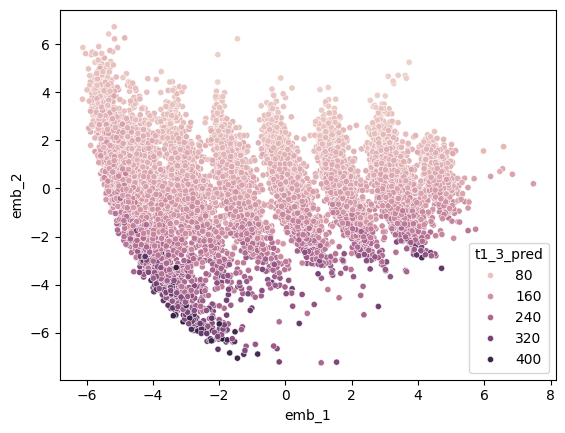

In [215]:
# sns.scatterplot(df[df['labels'].str.contains('t2')], x="emb_1", y="emb_2", hue="t1_3_pred")
sns.scatterplot(df, x="emb_1", y="emb_2", hue="t1_3_pred", s=20)
plt.show()
# sns.scatterplot(df[df['labels'] == 't2_3'], x="emb_1", y="emb_2", hue="rt_t2")
# plt.show()

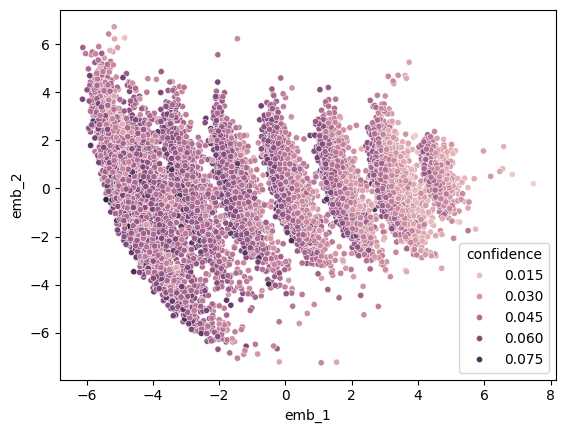

In [216]:
sns.scatterplot(df, x="emb_1", y="emb_2", hue="confidence", s=20)
plt.show()

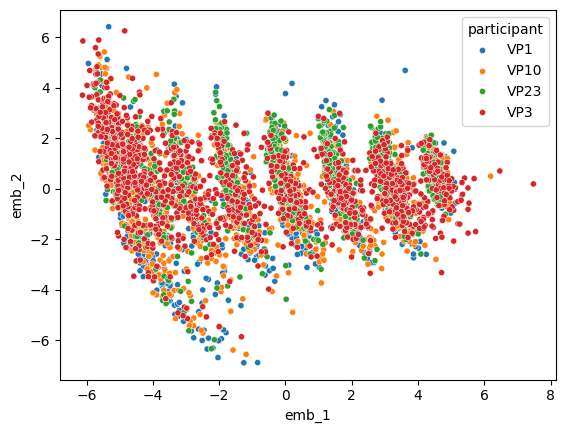

In [220]:
sns.scatterplot(df[df.participant.isin(splits[1])], x="emb_1", y="emb_2", hue="participant", s=20)
plt.show()

In [147]:
model = smf.ols("emb_2 ~ t1_3_pred", data=df).fit()
print(model.summary())
# 80% of variance in emb_2 is explained by t1_3_pred

                            OLS Regression Results                            
Dep. Variable:                  emb_2   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1062.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):          1.35e-224
Time:                        10:26:59   Log-Likelihood:                -68969.
No. Observations:               13864   AIC:                         1.379e+05
Df Residuals:                   13862   BIC:                         1.380e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.0728      0.983     31.612      0.0

In [126]:
from sklearn.preprocessing import StandardScaler

# Create a copy to avoid modifying your original dataframe
df_scaled = df.copy()

# Initialize the scaler
scaler = StandardScaler()

# Scale the predictors
df_scaled[['confidence', 't1_3_pred']] = scaler.fit_transform(df_scaled[['confidence', 't1_3_pred']])

In [132]:
model = smf.ols("emb_1 ~ confidence + rt_t1", data=df_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  emb_1   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     1879.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:24:49   Log-Likelihood:                -33986.
No. Observations:               13864   AIC:                         6.798e+04
Df Residuals:                   13861   BIC:                         6.800e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9981      0.081     24.543      0.0

In [127]:
model = smf.ols("emb_1 ~ confidence + t1_3_pred", data=df_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  emb_1   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1692.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:24:13   Log-Likelihood:                -34135.
No. Observations:               13864   AIC:                         6.828e+04
Df Residuals:                   13861   BIC:                         6.830e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0135      0.024      0.559      0.5

In [65]:
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import statsmodels.api as sm
X = dmatrix("C(participant) + C(condition) + epoch + t1_3_pred + rt_t1 + rt_t2 + C(order_idx) + block_idx", data=df, return_type='dataframe')
y = df['emb_1']
model = sm.OLS(y, X).fit()
print(model.summary())
# 80% of variance in emb_2 is explained by t1_3_pred

                            OLS Regression Results                            
Dep. Variable:                  emb_1   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2068.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        09:42:00   Log-Likelihood:                -23664.
No. Observations:               13864   AIC:                         4.739e+04
Df Residuals:                   13832   BIC:                         4.763e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

In [53]:
import mne

def plot_peak_topos(df, clusters, event='t1_3', positions=None):

    set_seaborn_style()
    fig, axs = plt.subplots(1, len(clusters), figsize=(3 * len(clusters), 6))

    for i, cluster in enumerate(clusters):
        df_cluster = df[df['clusters'] == cluster]
        if df_cluster.empty:
            continue

        peak_values = df_cluster[f"{event}_peak_values"].apply(eval).values
        peak_values = np.array([np.array(x) for x in peak_values]).mean(axis=0)[:64]

        mne.viz.plot_topomap(peak_values, positions, axes=axs[i], show=False, cmap='Spectral_r')
        axs[i].set_title(f"Cluster: {cluster}")

    fig.suptitle("Topomap Comparisons for response clusters", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [54]:
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"
epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...


    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
834 matching events found
No baseline correction applied
0 projection items activated


In [69]:
plot_peak_topos(df, event='t1_3', clusters=[2, 3, 4, 5], positions=positions)
plt.show()

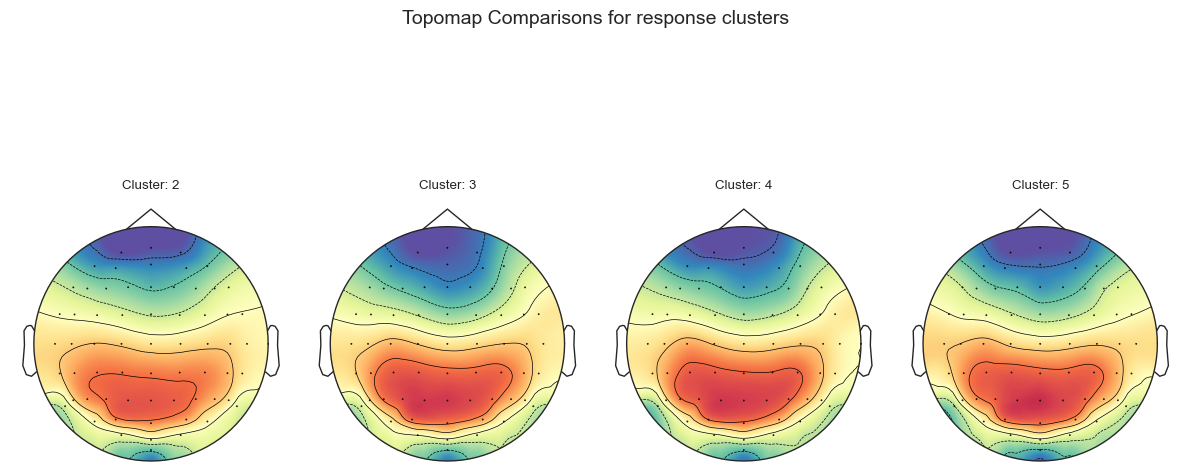

In [77]:
plot_peak_topos(df, event='t2_3', clusters=[2, 3, 4, 5], positions=positions)
plt.show()

In [63]:
df = df[df['clusters'].isin([2, 3, 4, 5])]

In [81]:
df.groupby(['clusters'])['rt_t1'].mean()

clusters
2.0    162.531982
3.0    143.644457
4.0    145.678669
5.0    128.091688
Name: rt_t1, dtype: float64

In [80]:
# Get mean rt per cluster
df['relative_rt'] = df['t1_3_pred'] / df['rt_t1']
df.groupby(['clusters'])['relative_rt'].mean()

/tmp/ipykernel_880319/2668720020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_rt'] = df['t1_3_pred'] / df['rt_t1']


clusters
2.0    0.942075
3.0    0.954683
4.0    0.948805
5.0    0.967555
Name: relative_rt, dtype: float64

In [76]:
df['relative_rt'] = df['t2_3_pred'] / (df['rt_t2'] + (df['interval'] * 250))
df.groupby(['clusters'])['relative_rt'].mean()

/tmp/ipykernel_880319/3210128906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_rt'] = df['t2_3_pred'] / (df['rt_t2'] + (df['interval'] * 250))


clusters
2.0    0.959499
3.0    0.969363
4.0    0.966947
5.0    0.963187
Name: relative_rt, dtype: float64

In [82]:
df

participant  epoch labels  clusters condition  interval  rt_t1  \
2             VP1      0   t1_3       2.0      long  1.197266    364   
5             VP1      0   t2_3       3.0      long  1.197266    364   
8             VP1      1   t1_3       2.0      long  1.177734    183   
11            VP1      1   t2_3       3.0      long  1.177734    183   
14            VP1      2   t1_3       2.0     short  0.275391    146   
...           ...    ...    ...       ...       ...       ...    ...   
83357         VP9   1291   t2_3       3.0     short  0.277344    197   
83360         VP9   1292   t1_3       4.0     short  0.277344    153   
83363         VP9   1292   t2_3       2.0     short  0.277344    153   
83366         VP9   1293   t1_3       3.0     short  0.277344    141   
83369         VP9   1293   t2_3       2.0     short  0.277344    141   

       rt_samples  correct_t1  t1_1_pred  ...   t2_3_pred t2_3_true  \
2             364         1.0       29.0  ...  440.316406     140.0   
5             364         1.0       29.0  ...  440.316406     140.0   
8             183         1.0       30.0  ...  445.433594     152.0   
11            183         1.0       30.0  ...  445.433594     152.0   
14            146         1.0       23.0  ...  209.847656     114.0   
...           ...         ...        ...  ...         ...       ...   
83357         197         1.0       28.0  ...  292.335938     215.0   
83360         153         1.0       31.0  ...  212.335938     133.0   
83363         153         1.0       31.0  ...  212.335938     133.0   
83366         141         1.0       11.0  ...  231.335938     161.0   
83369         141         1.0       11.0  ...  231.335938     161.0   

                                        t2_3_peak_values  event_0_idx  \
2      [-2.3122332096099854, -0.6491920351982117, -3....            0   
5      [-2.3122332096099854, -0.6491920351982117, -3....            0   
8      [-5.919742107391357, -4.222636699676514, -4.66...            0   
11     [-5.919742107391357, -4.222636699676514, -4.66...            0   
14     [-0.3750690519809723, 1.2942081689834595, -0.0...            0   
...                                                  ...          ...   
83357  [0.5038385987281799, 1.2843936681747437, -3.46...            0   
83360  [-2.283954620361328, -4.022957801818848, -0.00...            0   
83363  [-2.283954620361328, -4.022957801818848, -0.00...            0   
83366  [0.35982605814933777, 1.422956943511963, 1.040...            0   
83369  [0.35982605814933777, 1.422956943511963, 1.040...            0   

      event_1_idx  event_2_idx  event_3_idx event_4_idx  event_5_idx  \
2               1            3            2           4            5   
5               1            3            2           4            5   
8               1            2            3           4            5   
11              1            2            3           4            5   
14              1            3            2           4            5   
...           ...          ...          ...         ...          ...   
83357           1            3            4           2            5   
83360           1            3            2           4            5   
83363           1            3            2           4            5   
83366           1            3            2           4            5   
83369           1            3            2           4            5   

       relative_rt  
2         0.975275  
5         0.975275  
8         0.928962  
11        0.928962  
14        0.938356  
...            ...  
83357     0.964467  
83360     0.954248  
83363     0.954248  
83366     0.957447  
83369     0.957447  

[27791 rows x 36 columns]

In [29]:
weird_response = df[df['clusters'] == 3]
other_response = df[df['clusters'] == 2]

In [91]:
print(weird_response.labels.value_counts())
print(other_response.labels.value_counts())


labels
t1_3    1154
t2_3      14
Name: count, dtype: int64
labels
t2_3    13880
t1_3    12741
t1_2       11
Name: count, dtype: int64


In [92]:
print(weird_response.condition.value_counts(normalize=True))
print(other_response.condition.value_counts(normalize=True))


condition
short    0.844178
long     0.155822
Name: proportion, dtype: float64
condition
short    0.848528
long     0.151472
Name: proportion, dtype: float64


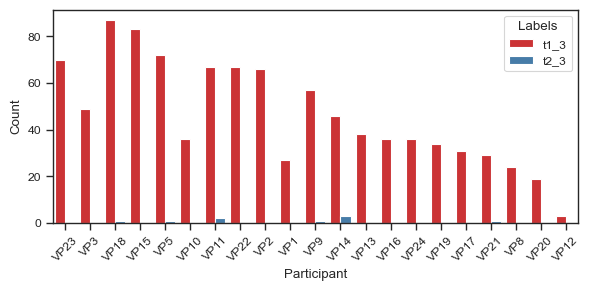

In [47]:
# Plot occurences per participant as ratio of all responses
plt.figure(figsize=(6, 3))
sns.countplot(data=weird_response[weird_response['condition'] == 'short'], x='participant', hue='labels', palette='Set1', order=weird_response['participant'].value_counts().index)
plt.xlabel('Participant')
plt.ylabel('Count')
plt.legend(title='Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

In [ ]:
# Print percentage correct t1
print(weird_response.correct_t1.value_counts(normalize=True))
print(other_response.correct_t1.value_counts(normalize=True))

# Print percentage correct t2
print(weird_response.correct_t2.value_counts(normalize=True))
print(other_response.correct_t2.value_counts(normalize=True))

correct_t1
1.0    0.875755
0.0    0.124245
Name: proportion, dtype: float64
correct_t1
1.0    0.89144
0.0    0.10856
Name: proportion, dtype: float64
correct_t2
1.0    0.892148
0.0    0.107852
Name: proportion, dtype: float64
correct_t2
1.0    0.88883
0.0    0.11117
Name: proportion, dtype: float64


In [70]:
weird_response

participant  epoch labels  clusters condition  interval  rt_t1  \
242           VP1     50   t1_3       3.0      long  1.175781    110   
326           VP1     70   t1_3       3.0     short  0.277344    107   
368           VP1     79   t1_3       3.0     short  0.275391    166   
392           VP1     83   t1_3       3.0     short  0.277344     98   
488           VP1    104   t1_3       3.0      long  1.175781    134   
...           ...    ...    ...       ...       ...       ...    ...   
83162         VP9   1235   t1_3       3.0     short  0.275391    129   
83174         VP9   1237   t1_3       3.0     short  0.277344    120   
83258         VP9   1262   t1_3       3.0     short  0.277344    124   
83270         VP9   1264   t1_3       3.0     short  0.277344    108   
83342         VP9   1287   t1_3       3.0     short  0.277344    136   

       rt_samples  correct_t1  t1_1_pred  ...  \
242           110         1.0       24.0  ...   
326           107         1.0       31.0  ...   
368           166         1.0       26.0  ...   
392            98         1.0       21.0  ...   
488           134         1.0       26.0  ...   
...           ...         ...        ...  ...   
83162         129         1.0       15.0  ...   
83174         120         1.0       27.0  ...   
83258         124         1.0       15.0  ...   
83270         108         1.0       12.0  ...   
83342         136         1.0       30.0  ...   

                                        t2_2_peak_values   t2_3_pred  \
242    [-1.2721362113952637, -1.8271845579147339, -1....  460.945312   
326    [-0.9999696016311646, -0.4283214509487152, -1....  293.335938   
368    [-1.8918497562408447, -2.455796241760254, -1.1...  311.847656   
392    [1.3121532201766968, 1.4966752529144287, 0.519...  304.335938   
488    [0.7761244773864746, 0.9175257086753845, 1.420...  474.945312   
...                                                  ...         ...   
83162  [1.201027274131775, 2.630676746368408, 3.36881...  192.847656   
83174  [-2.7469794750213623, -4.879026889801025, -0.6...  201.335938   
83258  [-2.357642650604248, -2.432419776916504, -4.45...  219.335938   
83270  [-3.1545040607452393, -3.307178258895874, -2.0...  262.335938   
83342  [1.3693780899047852, 1.3332921266555786, 0.152...  198.335938   

       t2_3_true                                   t2_3_peak_values  \
242        167.0  [0.7548750638961792, 2.0386416912078857, -0.14...   
326        190.0  [0.4269174635410309, 1.927866816520691, 0.3594...   
368        241.0  [-3.1189873218536377, -3.511545181274414, -2.1...   
392        209.0  [0.6209398508071899, 1.2676482200622559, 0.068...   
488        183.0  [-0.5269138216972351, -1.4776408672332764, -1....   
...          ...                                                ...   
83162      110.0  [1.705235242843628, 0.9030520915985107, -1.325...   
83174      111.0  [-1.153473973274231, -1.0672101974487305, -1.7...   
83258      146.0  [0.5375560522079468, 0.879055917263031, -0.210...   
83270      194.0  [-1.796628713607788, -2.997243642807007, -1.06...   
83342      104.0  [-1.7010445594787598, -3.2945079803466797, -2....   

      event_0_idx  event_1_idx  event_2_idx event_3_idx  event_4_idx  \
242             0            1            2           3            4   
326             0            1            3           2            4   
368             0            3            1           2            4   
392             0            1            2           3            4   
488             0            1            2           3            4   
...           ...          ...          ...         ...          ...   
83162           0            1            3           2            4   
83174           0            1            3           2            4   
83258           0            1            3           2            4   
83270           0            3            1           2            4   
83342           0            1            

In [31]:
import mne

def plot_peak_topos(df_weird, df_normal, events=None, positions=None):
    if events is None:
        # Default events to plot
        events = [f"t{i}_{j}" for i in [1, 2] for j in [1, 2, 3]]

    set_seaborn_style()
    n_events = len(events)
    fig, axs = plt.subplots(2, n_events, figsize=(3 * n_events, 6))  # 2 rows (weird, normal)

    for i, event in enumerate(events):
        # --- Weird group
        peak_values_weird = df_weird[f"{event}_peak_values"].apply(eval).values
        peak_values_weird = np.array([np.array(x) for x in peak_values_weird]).mean(axis=0)[:64]

        # --- Normal group
        peak_values_normal = df_normal[f"{event}_peak_values"].apply(eval).values
        peak_values_normal = np.array([np.array(x) for x in peak_values_normal]).mean(axis=0)[:64]

        # Plot topomaps
        mne.viz.plot_topomap(peak_values_weird, positions, axes=axs[0, i], show=False, cmap='Spectral_r')
        axs[0, i].set_title(f"Weird: {event}")

        mne.viz.plot_topomap(peak_values_normal, positions, axes=axs[1, i], show=False, cmap='Spectral_r')
        axs[1, i].set_title(f"Normal: {event}")

    fig.suptitle("Topomap Comparisons for Weird vs. Normal", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [32]:
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"
epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...


    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
834 matching events found
No baseline correction applied
0 projection items activated


In [42]:
other_response[other_response['participant'] == p]

participant  epoch labels  clusters condition  interval  rt_t1  \
52127        VP22      1   t2_3       2.0     short  0.275391    128   
52130        VP22      3   t1_3       2.0     short  0.277344    123   
52133        VP22      3   t2_3       2.0     short  0.277344    123   
52136        VP22      4   t1_3       2.0     short  0.277344    126   
52139        VP22      4   t2_3       2.0     short  0.277344    126   
...           ...    ...    ...       ...       ...       ...    ...   
55661        VP22   1284   t2_3       2.0     short  0.275391    141   
55664        VP22   1286   t1_3       2.0     short  0.277344     96   
55667        VP22   1286   t2_3       2.0     short  0.277344     96   
55670        VP22   1294   t1_3       2.0     short  0.277344    166   
55673        VP22   1294   t2_3       2.0     short  0.277344    166   

       rt_samples  correct_t1  t1_1_pred  ...  \
52127         128         1.0       35.0  ...   
52130         123         1.0       20.0  ...   
52133         123         1.0       20.0  ...   
52136         126         1.0       18.0  ...   
52139         126         1.0       18.0  ...   
...           ...         ...        ...  ...   
55661         141         1.0       24.0  ...   
55664          96         1.0       21.0  ...   
55667          96         1.0       21.0  ...   
55670         166         1.0       25.0  ...   
55673         166         1.0       25.0  ...   

                                        t2_2_peak_values   t2_3_pred  \
52127  [-0.16206830739974976, -1.5507954359054565, -0...  208.847656   
52130  [-2.1031856536865234, -0.6161513328552246, 0.8...  200.335938   
52133  [-2.1031856536865234, -0.6161513328552246, 0.8...  200.335938   
52136  [-2.9533193111419678, -3.2883388996124268, 2.5...  163.335938   
52139  [-2.9533193111419678, -3.2883388996124268, 2.5...  163.335938   
...                                                  ...         ...   
55661  [-1.0273361206054688, -0.6923167705535889, 1.3...  167.847656   
55664  [-1.7413017749786377, -1.3983619213104248, 0.1...  163.335938   
55667  [-1.7413017749786377, -1.3983619213104248, 0.1...  163.335938   
55670  [-2.296268939971924, -0.803909420967102, 2.133...  219.335938   
55673  [-2.296268939971924, -0.803909420967102, 2.133...  219.335938   

       t2_3_true                                   t2_3_peak_values  \
52127      144.0  [-2.698064088821411, -4.439578533172607, 1.202...   
52130      125.0  [0.3056377172470093, 2.0924768447875977, -1.08...   
52133      125.0  [0.3056377172470093, 2.0924768447875977, -1.08...   
52136       81.0  [-0.6721940636634827, 0.5372104048728943, 0.10...   
52139       81.0  [-0.6721940636634827, 0.5372104048728943, 0.10...   
...          ...                                                ...   
55661       77.0  [-3.780301570892334, -2.720900297164917, 3.821...   
55664       80.0  [-0.5747030377388, -0.5320270657539368, 2.3665...   
55667       80.0  [-0.5747030377388, -0.5320270657539368, 2.3665...   
55670      131.0  [-2.057779312133789, -1.7887992858886719, 1.55...   
55673      131.0  [-2.057779312133789, -1.7887992858886719, 1.55...   

      event_0_idx  event_1_idx  event_2_idx event_3_idx  event_4_idx  \
52127           0            3            1           2            4   
52130           0            1            3           2            4   
52133           0            1            3           2            4   
52136           0            1            3           2            4   
52139           0            1            3           2            4   
...           ...          ...          ...         ...          ...   
55661           0            1            3           2            4   
55664           0            1            2           3            4   
55667           0            1            2           3            4   
55670           0            3            1           2            4   
55673           0            3            

In [43]:
splits

([np.str_('VP17'),
  np.str_('VP14'),
  np.str_('VP2'),
  np.str_('VP12'),
  np.str_('VP5'),
  np.str_('VP24'),
  np.str_('VP21'),
  np.str_('VP11'),
  np.str_('VP18'),
  np.str_('VP9'),
  np.str_('VP13'),
  np.str_('VP20'),
  np.str_('VP16'),
  np.str_('VP19'),
  np.str_('VP22'),
  np.str_('VP8'),
  np.str_('VP15')],
 [np.str_('VP1'), np.str_('VP3'), np.str_('VP23'), np.str_('VP10')],
 [])

In [45]:
weird_response

participant  epoch labels  clusters condition  interval  rt_t1  \
242           VP1     50   t1_3       3.0      long  1.175781    110   
326           VP1     70   t1_3       3.0     short  0.277344    107   
368           VP1     79   t1_3       3.0     short  0.275391    166   
392           VP1     83   t1_3       3.0     short  0.277344     98   
488           VP1    104   t1_3       3.0      long  1.175781    134   
...           ...    ...    ...       ...       ...       ...    ...   
83162         VP9   1235   t1_3       3.0     short  0.275391    129   
83174         VP9   1237   t1_3       3.0     short  0.277344    120   
83258         VP9   1262   t1_3       3.0     short  0.277344    124   
83270         VP9   1264   t1_3       3.0     short  0.277344    108   
83342         VP9   1287   t1_3       3.0     short  0.277344    136   

       rt_samples  correct_t1  t1_1_pred  ...  \
242           110         1.0       24.0  ...   
326           107         1.0       31.0  ...   
368           166         1.0       26.0  ...   
392            98         1.0       21.0  ...   
488           134         1.0       26.0  ...   
...           ...         ...        ...  ...   
83162         129         1.0       15.0  ...   
83174         120         1.0       27.0  ...   
83258         124         1.0       15.0  ...   
83270         108         1.0       12.0  ...   
83342         136         1.0       30.0  ...   

                                        t2_2_peak_values   t2_3_pred  \
242    [-1.2721362113952637, -1.8271845579147339, -1....  460.945312   
326    [-0.9999696016311646, -0.4283214509487152, -1....  293.335938   
368    [-1.8918497562408447, -2.455796241760254, -1.1...  311.847656   
392    [1.3121532201766968, 1.4966752529144287, 0.519...  304.335938   
488    [0.7761244773864746, 0.9175257086753845, 1.420...  474.945312   
...                                                  ...         ...   
83162  [1.201027274131775, 2.630676746368408, 3.36881...  192.847656   
83174  [-2.7469794750213623, -4.879026889801025, -0.6...  201.335938   
83258  [-2.357642650604248, -2.432419776916504, -4.45...  219.335938   
83270  [-3.1545040607452393, -3.307178258895874, -2.0...  262.335938   
83342  [1.3693780899047852, 1.3332921266555786, 0.152...  198.335938   

       t2_3_true                                   t2_3_peak_values  \
242        167.0  [0.7548750638961792, 2.0386416912078857, -0.14...   
326        190.0  [0.4269174635410309, 1.927866816520691, 0.3594...   
368        241.0  [-3.1189873218536377, -3.511545181274414, -2.1...   
392        209.0  [0.6209398508071899, 1.2676482200622559, 0.068...   
488        183.0  [-0.5269138216972351, -1.4776408672332764, -1....   
...          ...                                                ...   
83162      110.0  [1.705235242843628, 0.9030520915985107, -1.325...   
83174      111.0  [-1.153473973274231, -1.0672101974487305, -1.7...   
83258      146.0  [0.5375560522079468, 0.879055917263031, -0.210...   
83270      194.0  [-1.796628713607788, -2.997243642807007, -1.06...   
83342      104.0  [-1.7010445594787598, -3.2945079803466797, -2....   

      event_0_idx  event_1_idx  event_2_idx event_3_idx  event_4_idx  \
242             0            1            2           3            4   
326             0            1            3           2            4   
368             0            3            1           2            4   
392             0            1            2           3            4   
488             0            1            2           3            4   
...           ...          ...          ...         ...          ...   
83162           0            1            3           2            4   
83174           0            1            3           2            4   
83258           0            1            3           2            4   
83270           0            3            1           2            4   
83342           0            1            

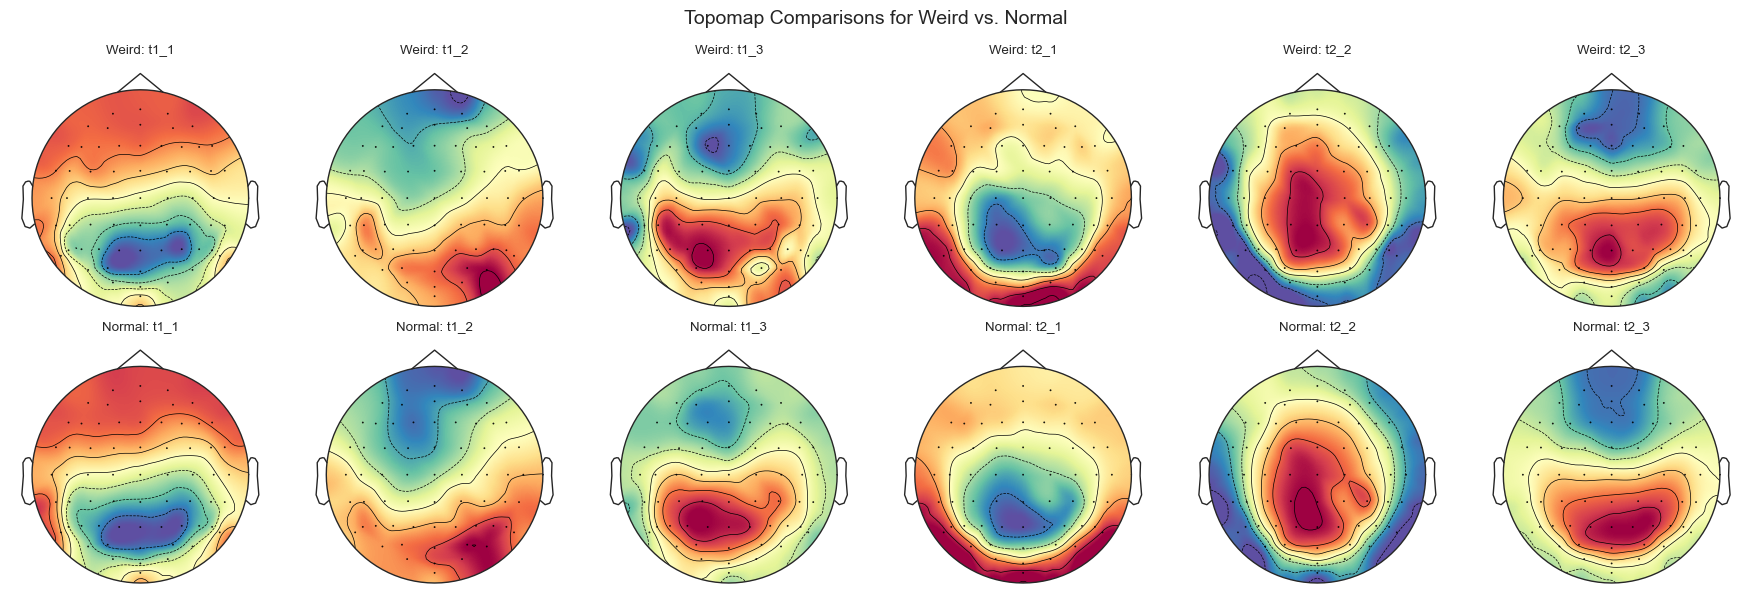

In [44]:
p = 'VP23'
plot_peak_topos(weird_response[weird_response['participant'] == p], other_response[other_response['participant'] == p], positions=positions)
plt.tight_layout()
plt.show()

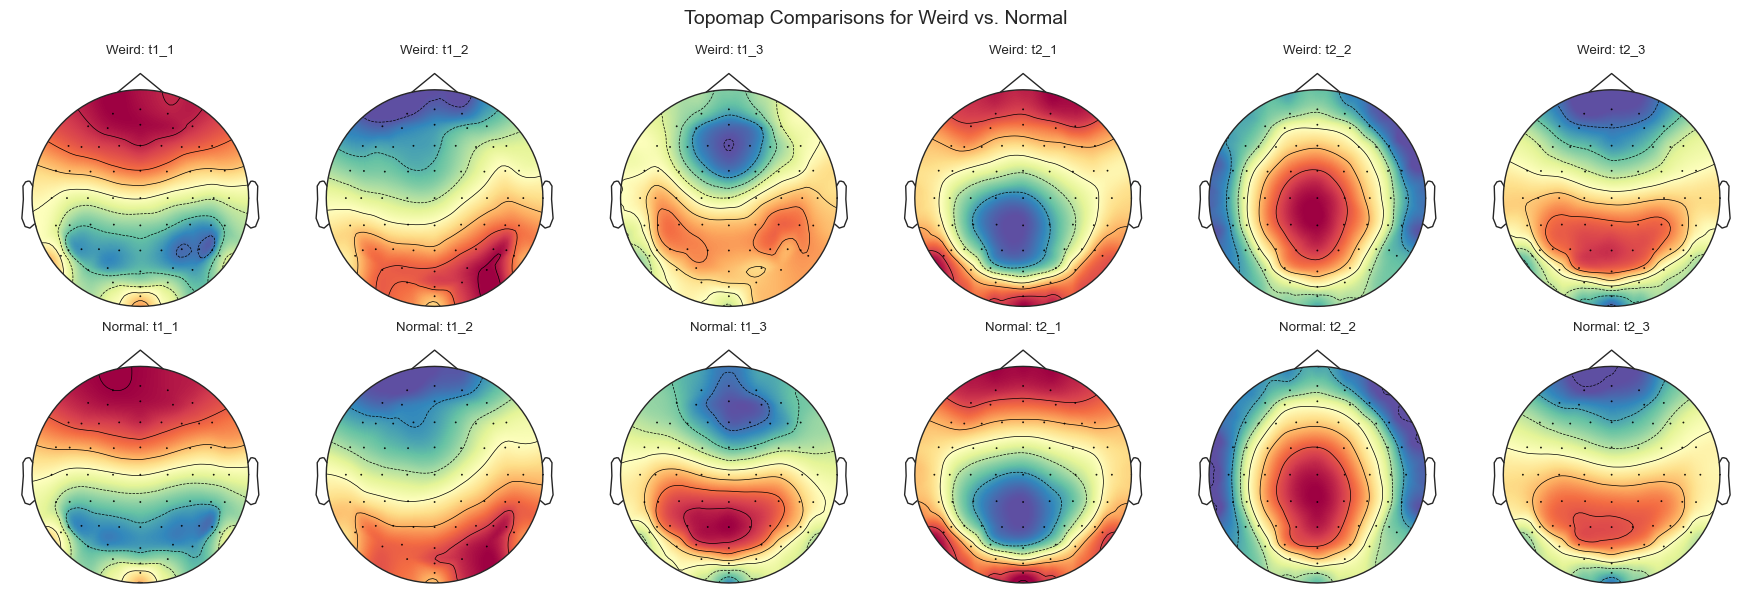

In [46]:
plot_peak_topos(weird_response, other_response, positions=positions)
plt.tight_layout()
plt.show()

count    1168.000000
mean        1.894692
std         2.405372
min       -10.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        23.000000
dtype: float64
count    26632.000000
mean         0.248160
std          2.855388
min        -21.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max         26.000000
dtype: float64


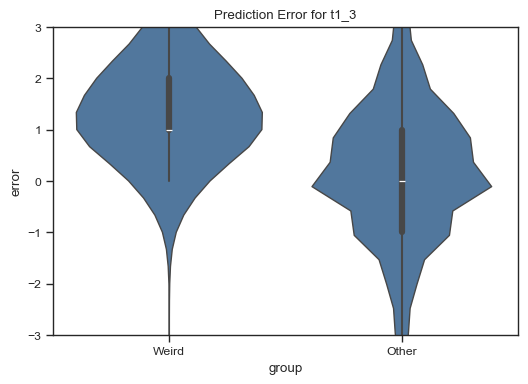

In [ ]:
# Compute errors
# Note that this might be a bit less valid in short condition, since we do not use it
weird_errors = weird_response.t1_3_pred - weird_response.t1_3_true
other_errors = other_response.t1_3_pred - other_response.t1_3_true

# Combine into a DataFrame
df = pd.DataFrame({
    "error": np.concatenate([weird_errors, other_errors]),
    "group": ["Weird"] * len(weird_errors) + ["Other"] * len(other_errors)
})
print(weird_errors.describe())
print(other_errors.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="group", y="error", cut=0)
plt.title("Prediction Error for t1_3")
plt.ylim(-3, 3)
plt.show()

count    1168.000000
mean      128.130993
std        20.960913
min        86.000000
25%       114.000000
50%       125.000000
75%       138.250000
max       251.000000
Name: rt_t1, dtype: float64
count    26632.000000
mean       153.946944
std         48.122024
min         65.000000
25%        123.000000
50%        142.000000
75%        172.000000
max        436.000000
Name: rt_t1, dtype: float64


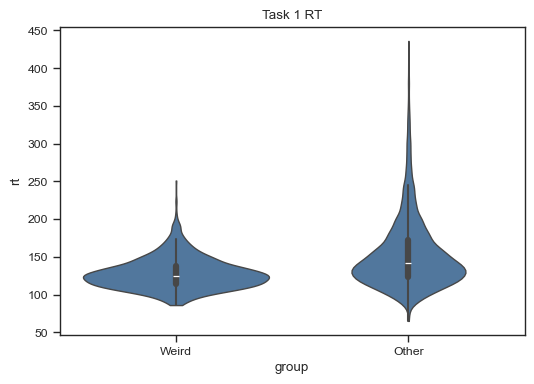

In [110]:


# Combine into a DataFrame
df = pd.DataFrame({
    "rt": np.concatenate([weird_response.rt_t1, other_response.rt_t1]),
    "group": ["Weird"] * len(weird_response.rt_t1) + ["Other"] * len(other_response.rt_t1)
})
print(weird_response.rt_t1.describe())
print(other_response.rt_t1.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="group", y="rt", cut=0)
plt.title("Task 1 RT")
# plt.ylim(-3, 3)
plt.show()

count    1168.000000
mean      157.068493
std        53.236747
min        69.000000
25%       122.000000
50%       146.000000
75%       178.250000
max       434.000000
Name: rt_t2, dtype: float64
count    26632.000000
mean       175.117791
std         66.210779
min         62.000000
25%        130.000000
50%        159.000000
75%        203.000000
max        436.000000
Name: rt_t2, dtype: float64


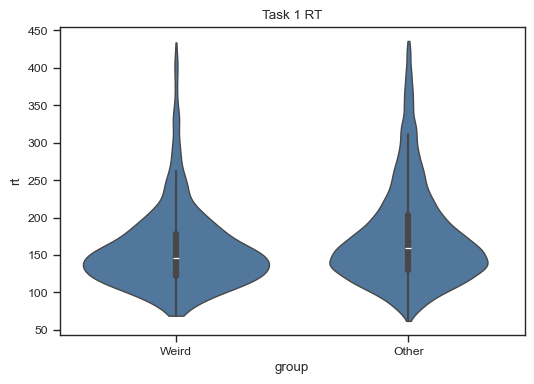

In [ ]:
df = pd.DataFrame({
    "rt": np.concatenate([weird_response.rt_t2, other_response.rt_t2]),
    "group": ["Weird"] * len(weird_response.rt_t2) + ["Other"] * len(other_response.rt_t2)
})
print(weird_response.rt_t2.describe())
print(other_response.rt_t2.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="group", y="rt", cut=0)
plt.title("Task 1 RT")
# plt.ylim(-3, 3)
plt.show()

count    1168.000000
mean        0.967548
std         0.007310
min         0.861386
25%         0.964602
50%         0.968000
75%         0.971014
max         0.984064
dtype: float64
count    26632.000000
mean         0.947235
std          0.022059
min          0.773438
25%          0.936364
50%          0.952381
75%          0.962963
max          0.990244
dtype: float64


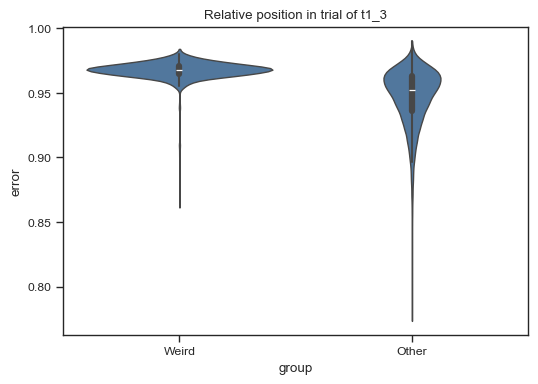

In [48]:
# Compute errors
# Note that this might be a bit less valid in short condition, since we do not use it
weird_errors = weird_response.t1_3_pred / weird_response.rt_t1
other_errors = other_response.t1_3_pred / other_response.rt_t1

# Combine into a DataFrame
df = pd.DataFrame({
    "error": np.concatenate([weird_errors, other_errors]),
    "group": ["Weird"] * len(weird_errors) + ["Other"] * len(other_errors)
})
print(weird_errors.describe())
print(other_errors.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="group", y="error", cut=0)
plt.title("Relative position in trial of t1_3")
# plt.ylim(-3, 3)
plt.show()
# Seems to occur later in trial (96.75% instead of 94.72%, but on faster trials)

count    1168.000000
mean      128.288477
std        81.341117
min         9.335938
25%        72.335938
50%        97.335938
75%       152.335938
max       375.945312
dtype: float64
count    26632.000000
mean       122.719178
std         75.739943
min       -189.152344
25%         70.335938
50%         97.847656
75%        151.335938
max        393.433594
dtype: float64


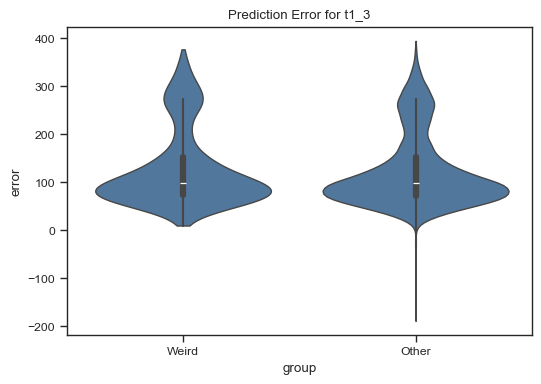

In [ ]:
# Compute errors
# Note that this might be a bit less valid in short condition, since we do not use it
weird_errors = weird_response.t2_3_pred - weird_response.t1_3_pred
other_errors = other_response.t2_3_pred - other_response.t1_3_pred

# Combine into a DataFrame
df = pd.DataFrame({
    "error": np.concatenate([weird_errors, other_errors]),
    "group": ["Weird"] * len(weird_errors) + ["Other"] * len(other_errors)
})
print(weird_errors.describe())
print(other_errors.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="group", y="error", cut=0)
plt.title("Inter Response Interval (t2_3 - t1_3)")
# plt.ylim(-3, 3)
plt.show()

count    1168.000000
mean       -4.059075
std         0.701891
min       -15.000000
25%        -4.000000
50%        -4.000000
75%        -4.000000
max        -3.000000
dtype: float64
count    26632.000000
mean        -7.711625
std          3.043495
min        -30.000000
25%         -9.000000
50%         -7.000000
75%         -5.000000
max         -3.000000
dtype: float64


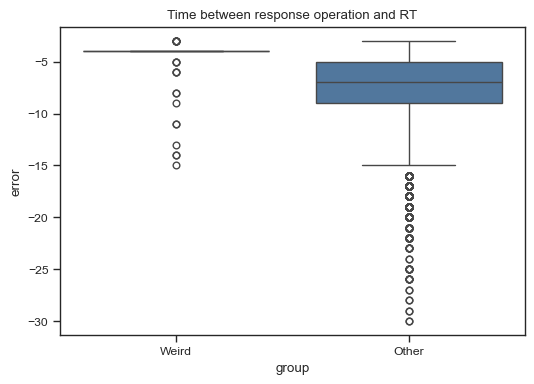

In [51]:
weird_errors = weird_response.t1_3_pred - weird_response.rt_t1
other_errors = other_response.t1_3_pred - other_response.rt_t1

# Combine into a DataFrame
df = pd.DataFrame({
    "error": np.concatenate([weird_errors, other_errors]),
    "group": ["Weird"] * len(weird_errors) + ["Other"] * len(other_errors)
})
print(weird_errors.describe())
print(other_errors.describe())
# Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="group", y="error")
plt.title("Time between response operation and RT")
# plt.ylim(-3, 3)
plt.show()
# Seems to occur later in trial (96.75% instead of 94.72%, but on faster trials)